# Multitask GP Regression using pymc
Source: https://docs.gpytorch.ai/en/latest/examples/03_Multitask_Exact_GPs/Multitask_GP_Regression.html

In [1]:
import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
# set the seed
np.random.seed(1)
from multi_ouputs import build_XY, ICM, LCM

In [2]:
import math
%matplotlib inline
%load_ext autoreload
%reload_ext autoreload
%autoreload 2

### Set up training data

In [3]:
train_x = np.linspace(0, 1, 20)

train_y = np.stack([
    np.sin(train_x * (2 * math.pi)) + np.random.randn(len(train_x)) * 0.2,
    np.cos(train_x * (2 * math.pi)) + np.random.randn(len(train_x)) * 0.2,
    np.cos(train_x * (1 * math.pi)) + np.random.randn(len(train_x)) * 0.1,
], -1)

In [4]:
train_x.shape, train_y.shape

((20,), (20, 3))

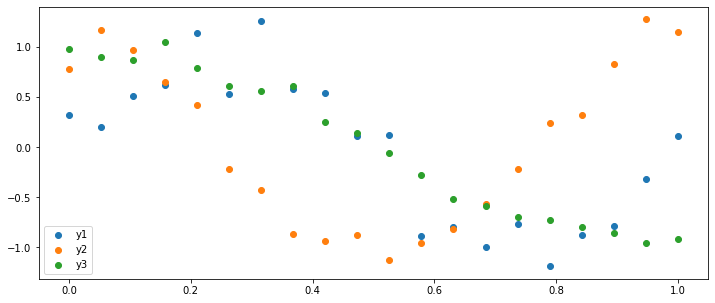

In [5]:
fig, ax = plt.subplots(1,1, figsize=(12,5))
ax.scatter(train_x, train_y[:,0])
ax.scatter(train_x, train_y[:,1])
ax.scatter(train_x, train_y[:,2])
plt.legend(["y1", "y2", "y3"])

In [6]:
train_x.shape, train_y.shape

((20,), (20, 3))

In [7]:
np.vstack([train_y[:,0], train_y[:,1], train_y[:,2]]).shape

(3, 20)

In [8]:
x = train_x.reshape(-1,1)
X, Y, _ = build_XY([x,x,x], 
                   [train_y[:,0].reshape(-1,1), 
                    train_y[:,1].reshape(-1,1), 
                    train_y[:,2].reshape(-1,1)])
x.shape, X.shape, Y.shape

((20, 1), (60, 2), (60, 1))

### ICM

In [9]:
with pm.Model() as model:
    ell = pm.Gamma("ell", alpha=3, beta=0.5)
    eta = pm.Gamma("eta", alpha=3, beta=0.5)
    cov = eta**2 * pm.gp.cov.ExpQuad(2, ls=ell, active_dims=[0])    

    icm = ICM(input_dim=2, active_dims=[1], num_outputs=3, kernel=cov)
    
    sigma = pm.HalfNormal("sigma", sigma=5)
    gp = pm.gp.Marginal(cov_func=icm())
    y_ = gp.marginal_likelihood("f", X, Y.squeeze(), noise=sigma)

In [10]:
%%time
with model:
    gp_trace = pm.sample(500, chains=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [ell, eta, ICM_W, ICM_kappa, sigma]


Sampling 1 chain for 1_000 tune and 500 draw iterations (1_000 + 500 draws total) took 18 seconds.


CPU times: user 50.4 s, sys: 1min 38s, total: 2min 29s
Wall time: 1min 11s


In [11]:
n_points = 200
x_new = np.linspace(-0.5, 1.5, n_points)[:, None]
X_new, _, _ = build_XY([x_new, x_new, x_new])

In [12]:
with model:
    preds = gp.conditional("preds", X_new)
    gp_samples = pm.sample_posterior_predictive(gp_trace, var_names=['preds'], random_seed=42)

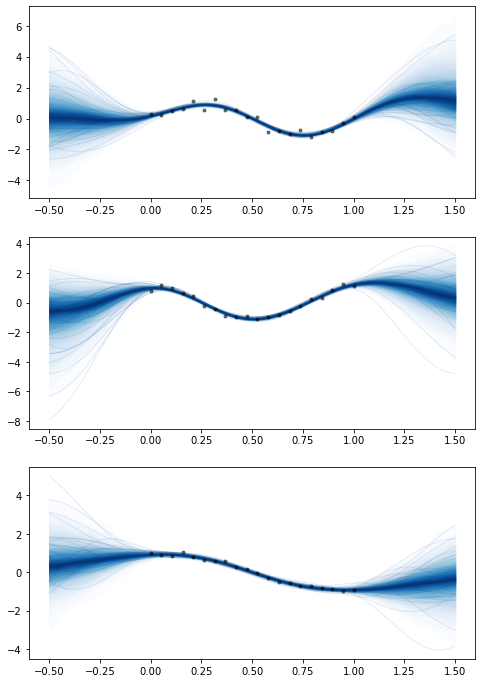

In [13]:
from pymc.gp.util import plot_gp_dist

f_pred = gp_samples.posterior_predictive["preds"].sel(chain=0)
fig, axes = plt.subplots(3,1, figsize=(8,12))

for idx in range(3):
    plot_gp_dist(axes[idx], f_pred[:,n_points*idx:n_points*(idx+1)], 
                 X_new[n_points*idx:n_points*(idx+1),0], 
                 palette="Blues", fill_alpha=0.5, samples_alpha=0.1)
    axes[idx].plot(x, train_y[:,idx], 'ok', ms=3, alpha=0.5, label="Data 1");

In [14]:
az.summary(gp_trace)

arviz - WARNING - Shape validation failed: input_shape: (1, 500), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"ICM_W[0, 0]",0.437,3.008,-4.731,6.564,0.154,0.115,391.0,358.0,NaN
"ICM_W[1, 0]",0.109,2.953,-5.656,5.208,0.168,0.153,341.0,226.0,NaN
"ICM_W[2, 0]",0.027,1.589,-3.376,2.739,0.080,0.075,411.0,315.0,NaN
ell,0.345,0.060,0.235,0.457,0.004,0.003,196.0,246.0,NaN
eta,0.614,0.263,0.240,1.146,0.022,0.016,162.0,174.0,NaN
ICM_kappa[0],5.183,2.160,1.795,9.285,0.098,0.070,455.0,401.0,NaN
ICM_kappa[1],5.407,2.430,1.568,10.174,0.095,0.072,628.0,240.0,NaN
ICM_kappa[2],3.869,1.716,0.901,6.920,0.089,0.063,348.0,315.0,NaN
sigma,0.172,0.018,0.140,0.206,0.001,0.001,507.0,365.0,NaN


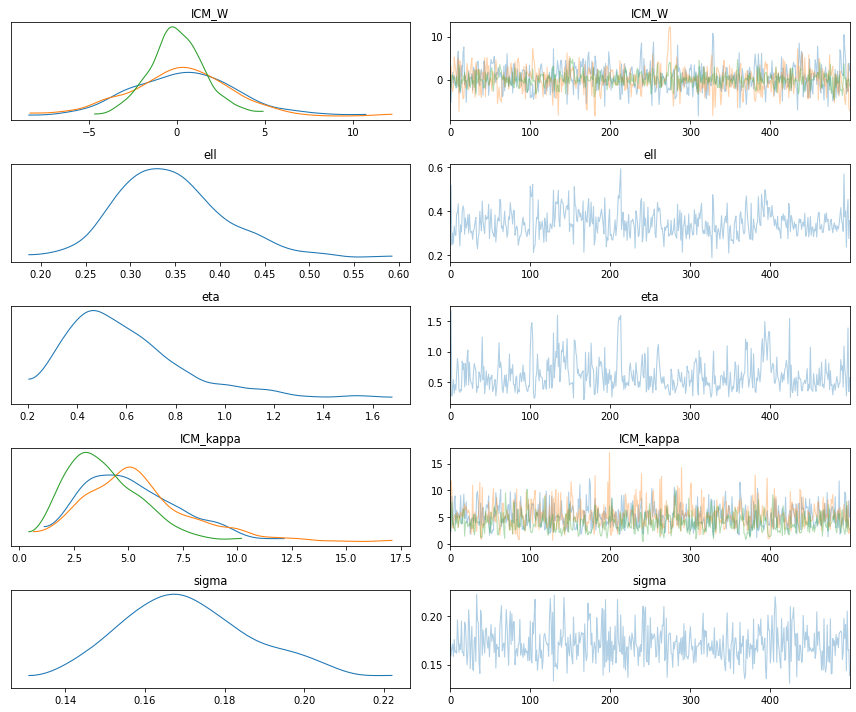

In [15]:
az.plot_trace(gp_trace);
plt.tight_layout()

### LCM

In [16]:
with pm.Model() as model:
    ell = pm.Gamma("ell", alpha=2, beta=0.5)
    eta = pm.Gamma("eta", alpha=2, beta=0.5)
    cov = eta**2 * pm.gp.cov.ExpQuad(2, ls=ell, active_dims=[0])
    
    ell2 = pm.Gamma("ell2", alpha=2, beta=0.5)
    eta2 = pm.Gamma("eta2", alpha=2, beta=0.5)
    cov2 = eta2**2 * pm.gp.cov.Matern32(2, ls=ell2, active_dims=[0])
    
    
    lcm = LCM(input_dim=2, active_dims=[1], num_outputs=3, kernel_list=[cov, cov2])
    
    sigma = pm.HalfNormal("sigma", sigma=3)
    gp = pm.gp.Marginal(cov_func=lcm())
    y_ = gp.marginal_likelihood("f", X, Y.squeeze(), noise=sigma)

In [17]:
%%time
with model:
    gp_trace = pm.sample(500, chains=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [ell, eta, ell2, eta2, ICM_0_W, ICM_0_kappa, ICM_1_W, ICM_1_kappa, sigma]


Sampling 1 chain for 1_000 tune and 500 draw iterations (1_000 + 500 draws total) took 38 seconds.


CPU times: user 1min 41s, sys: 3min 26s, total: 5min 8s
Wall time: 56.9 s


In [18]:
with model:
    preds = gp.conditional("preds", X_new)
    gp_samples = pm.sample_posterior_predictive(gp_trace, var_names=['preds'], random_seed=42)

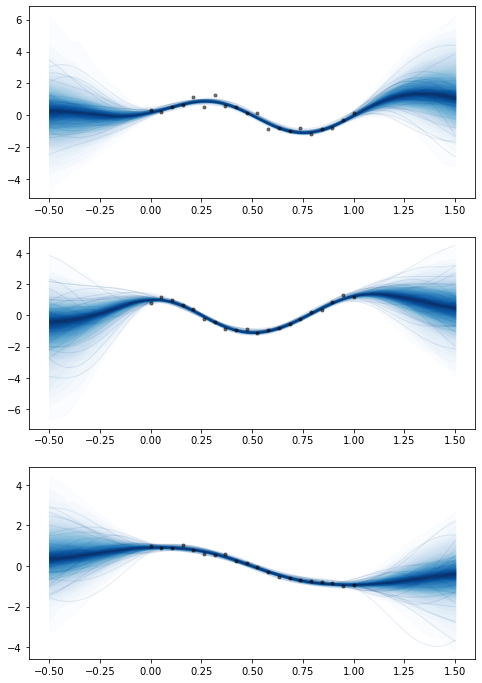

In [19]:
from pymc.gp.util import plot_gp_dist

f_pred = gp_samples.posterior_predictive["preds"].sel(chain=0)
fig, axes = plt.subplots(3,1, figsize=(8,12))

for idx in range(3):
    plot_gp_dist(axes[idx], f_pred[:,n_points*idx:n_points*(idx+1)], 
                 X_new[n_points*idx:n_points*(idx+1),0], 
                 palette="Blues", fill_alpha=0.5, samples_alpha=0.1)
    axes[idx].plot(x, train_y[:,idx], 'ok', ms=3, alpha=0.5, label="Data 1");

In [20]:
az.summary(gp_trace)

arviz - WARNING - Shape validation failed: input_shape: (1, 500), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"ICM_0_W[0, 0]",0.123,3.385,-5.800,6.869,0.199,0.190,316.0,263.0,NaN
"ICM_0_W[1, 0]",-0.255,3.345,-6.733,5.659,0.177,0.156,369.0,287.0,NaN
"ICM_0_W[2, 0]",0.024,1.805,-3.245,3.385,0.083,0.105,504.0,198.0,NaN
"ICM_1_W[0, 0]",-0.068,4.405,-7.834,7.976,0.185,0.190,570.0,434.0,NaN
"ICM_1_W[1, 0]",0.061,4.471,-8.668,8.366,0.198,0.205,532.0,259.0,NaN
"ICM_1_W[2, 0]",-0.072,4.156,-7.694,7.758,0.170,0.211,603.0,338.0,NaN
ell,0.338,0.057,0.227,0.440,0.003,0.002,322.0,409.0,NaN
eta,0.551,0.250,0.195,0.939,0.015,0.011,258.0,343.0,NaN
ell2,4.508,2.979,0.641,10.133,0.125,0.091,467.0,307.0,NaN
eta2,0.443,0.395,0.005,1.173,0.020,0.014,300.0,173.0,NaN


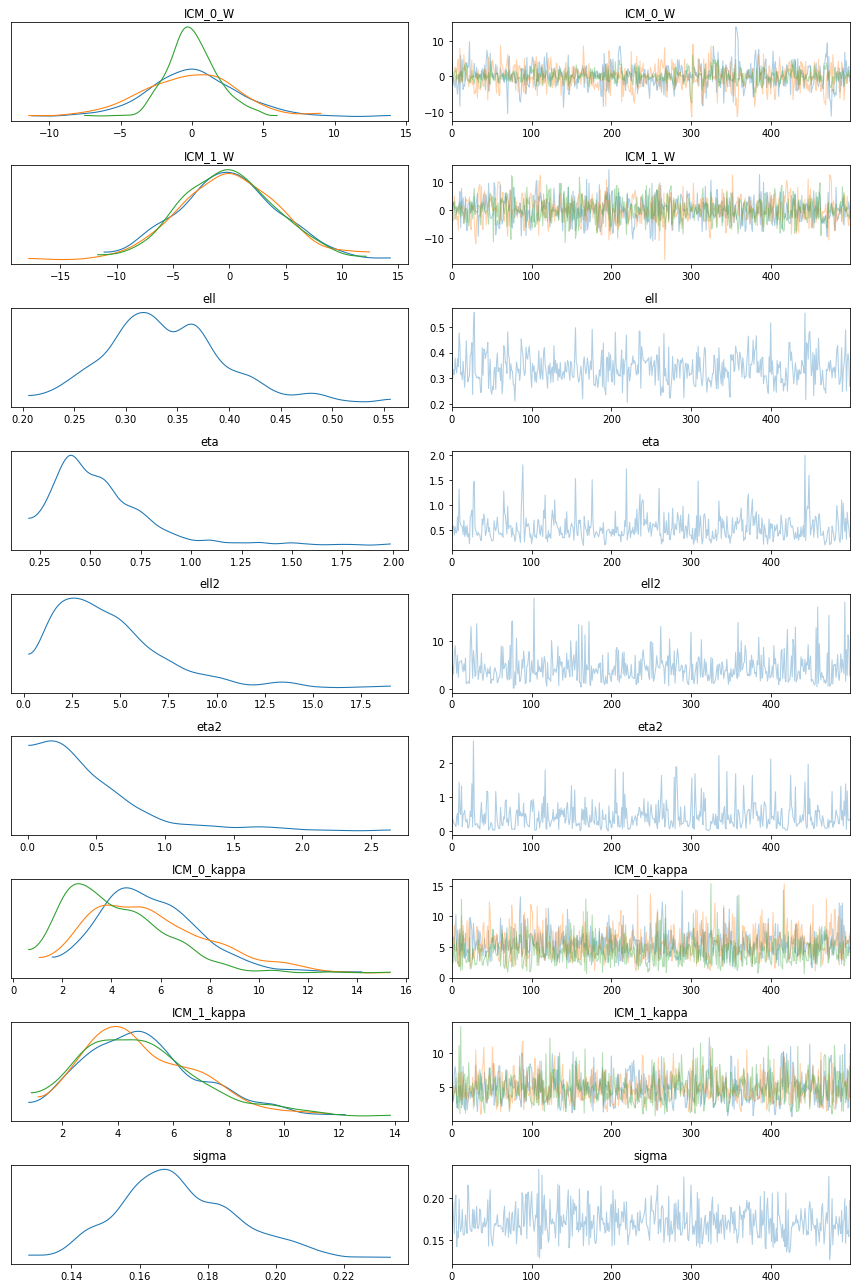

In [21]:
az.plot_trace(gp_trace);
plt.tight_layout()

In [22]:
with pm.Model() as model:
    ell = pm.Gamma("ell", alpha=2, beta=0.5, shape=2)
    eta = pm.Gamma("eta", alpha=2, beta=0.5, shape=2)
    kernels = [pm.gp.cov.ExpQuad, pm.gp.cov.Matern32]
    
    cov_list = [eta[idx] ** 2 * kernel(2,ls=ell[idx], active_dims=[0]) 
                for idx, kernel in zip(range(2), kernels)]
    
    lcm = LCM(input_dim=2, active_dims=[1], num_outputs=3, kernel_list=cov_list)
    
    sigma = pm.HalfNormal("sigma", sigma=3)
    gp = pm.gp.Marginal(cov_func=lcm())
    y_ = gp.marginal_likelihood("f", X, Y.squeeze(), noise=sigma)

In [23]:
%%time
with model:
    gp_trace = pm.sample(500, chains=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [ell, eta, ICM_0_W, ICM_0_kappa, ICM_1_W, ICM_1_kappa, sigma]


Sampling 1 chain for 1_000 tune and 500 draw iterations (1_000 + 500 draws total) took 56 seconds.
The acceptance probability does not match the target. It is 0.9275, but should be close to 0.8. Try to increase the number of tuning steps.


CPU times: user 2min 29s, sys: 5min 1s, total: 7min 31s
Wall time: 1min 10s


In [24]:
with model:
    preds = gp.conditional("preds", X_new)
    gp_samples = pm.sample_posterior_predictive(gp_trace, var_names=['preds'], random_seed=42)

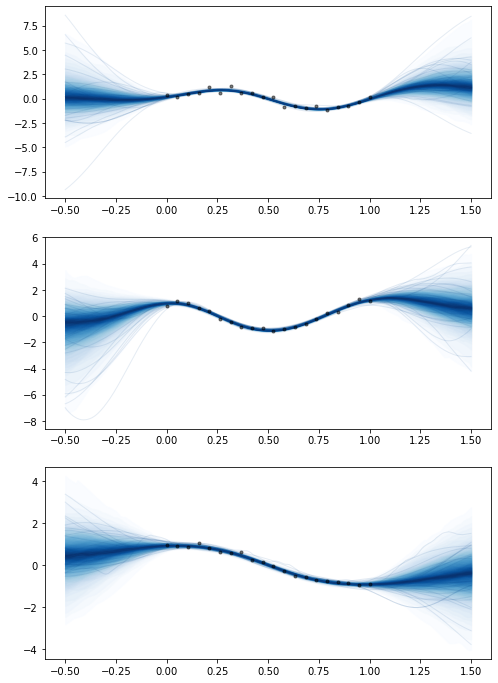

In [25]:
from pymc.gp.util import plot_gp_dist

f_pred = gp_samples.posterior_predictive["preds"].sel(chain=0)
fig, axes = plt.subplots(3,1, figsize=(8,12))

for idx in range(3):
    plot_gp_dist(axes[idx], f_pred[:,n_points*idx:n_points*(idx+1)], 
                 X_new[n_points*idx:n_points*(idx+1),0], 
                 palette="Blues", fill_alpha=0.5, samples_alpha=0.1)
    axes[idx].plot(x, train_y[:,idx], 'ok', ms=3, alpha=0.5, label="Data 1");

In [26]:
az.summary(gp_trace)

arviz - WARNING - Shape validation failed: input_shape: (1, 500), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"ICM_0_W[0, 0]",-0.182,3.381,-6.978,5.943,0.227,0.182,240.0,180.0,NaN
"ICM_0_W[1, 0]",0.152,3.227,-5.603,6.406,0.136,0.145,565.0,255.0,NaN
"ICM_0_W[2, 0]",-0.026,1.794,-2.699,4.423,0.070,0.093,707.0,258.0,NaN
"ICM_1_W[0, 0]",-0.190,4.523,-7.988,7.972,0.184,0.204,609.0,384.0,NaN
"ICM_1_W[1, 0]",-0.022,4.396,-8.604,8.249,0.180,0.218,621.0,327.0,NaN
"ICM_1_W[2, 0]",-0.003,3.837,-7.256,6.929,0.168,0.168,527.0,408.0,NaN
ell[0],0.345,0.071,0.228,0.465,0.004,0.003,395.0,249.0,NaN
ell[1],4.516,2.801,0.500,9.614,0.107,0.079,567.0,361.0,NaN
eta[0],0.564,0.252,0.193,1.034,0.012,0.008,453.0,348.0,NaN
eta[1],0.497,0.477,0.008,1.371,0.023,0.019,529.0,338.0,NaN


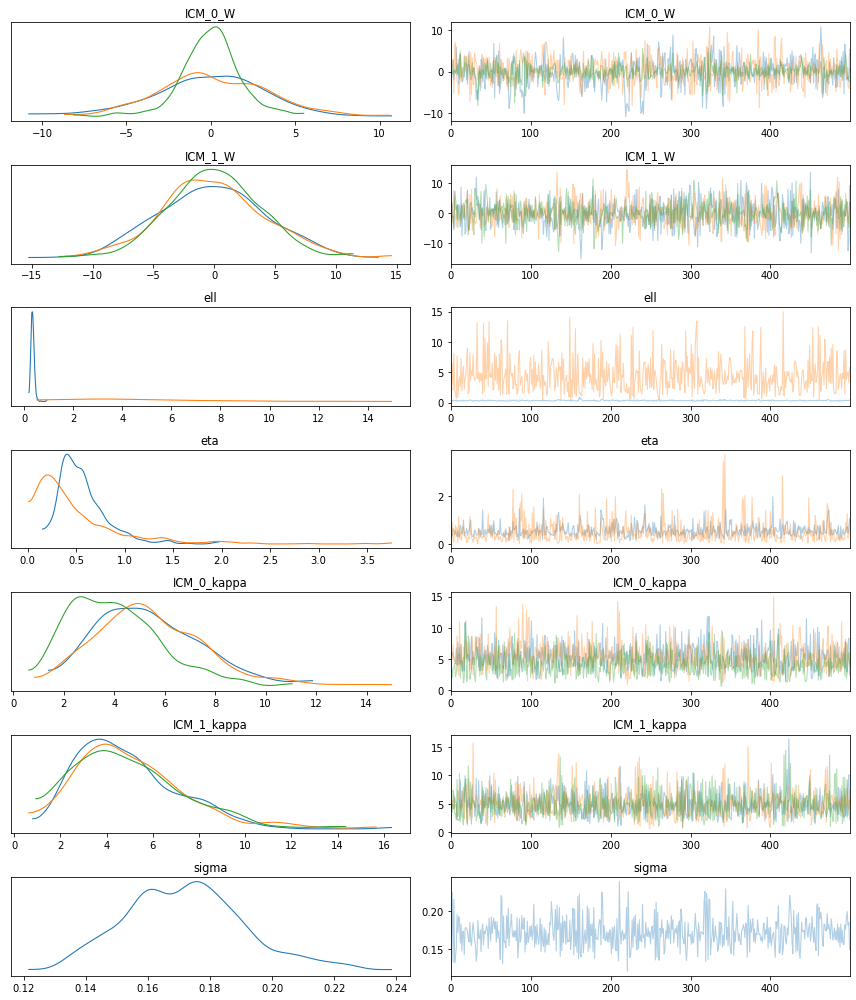

In [27]:
az.plot_trace(gp_trace);
plt.tight_layout()